# Language Toxicity Classification
Classifying abusive language in online forums
___
>Many online content providers depend upon an engaged and active online community, oftentimes for the creation of content itself, and need ways to ensure their site is an attractive destination for repeat web traffic. One of the ways they often achieve this is through an engaging online forum. However, when abusive community members are allowed to make a forum feel toxic, many of the other members can be turned off by this behavior and begin to limit, if not completely eliminate, their level of engagement in the community. This can lead to a reduction in content, along with the inherent resulting revenue losses, and a reduction in forum vibrancy. This can potentially lead to an overall stale web experience, inspiring others to abstain as well.

I’ll be using data from Kaggle’s Toxic Comment Classification Challenge in which a research initiative founded by Jigsaw and Google, known as the Conversation AI team, held a competition to determine if negative online behaviors, specifically comments that are rude, disrespectful or otherwise likely to make someone leave a discussion, could be identified and removed, thus improving online conversations. The challenge is to identify six different categories of abusive comments so that users interested in moderating an online discussion forum could allow degrees, or types, of profanity/abuse while eliminating others.


In [8]:
import numpy as np 
import pandas as pd
import pickle

#text
import sklearn
import spacy
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
import re
from collections import Counter

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
cores = multiprocessing.cpu_count()

#sklearn
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

#time
from tqdm.auto import tqdm # show progress bar
import time # time random searches

import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

In [2]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [3]:
comments = pd.read_csv('../Downloads/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
# We choose the first 100,569 rows because it will leave us with exactly 100,000 rows when we delete duplicates
comments = comments.iloc[:100569, 1:]

In [4]:
def clean_text(doc):
    # lower case and remove special characters\whitespace, (ignore case)|(ASCII-only matching)
    doc = re.sub('\n', ' ', doc)
    doc = re.sub(r'[^a-zA-Z\s\'\t]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    doc = re.sub(' +', ' ', doc)
    return doc

comments['comment_text'] = comments['comment_text'].apply(clean_text)
comments.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,d'aww he matches this background colour i'm se...,0,0,0,0,0,0
2,hey man i'm really not trying to edit war it's...,0,0,0,0,0,0
3,more i can't make any real suggestions on impr...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
5,congratulations from me as well use the tools ...,0,0,0,0,0,0
6,cocksucker before you piss around on my work,1,1,1,0,1,0
7,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0


# EDA

In [5]:
#Checking for any non-binary observations in our comment flags
comments.nunique()

comment_text     99959
toxic                2
severe_toxic         2
obscene              2
threat               2
insult               2
identity_hate        2
dtype: int64

> We have some duplicate rows that we will delete, keeping only the first occurence of each duplicate.

In [6]:
comments.drop_duplicates(keep='first', inplace=True)
comments.reset_index(drop=True, inplace=True)

# comments.to_pickle('raw_comments.pkl')
    
comments = pd.read_pickle('raw_comments.pkl')
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
comment_text     100000 non-null object
toxic            100000 non-null int64
severe_toxic     100000 non-null int64
obscene          100000 non-null int64
threat           100000 non-null int64
insult           100000 non-null int64
identity_hate    100000 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


> There are no null observations

In [7]:
#Checking if the 'toxic' flag is an umbrella designation assigned with all other flags
comments.iloc[:, 2:][comments.toxic==0].sum(axis=0)

severe_toxic       0
obscene          329
threat            17
insult           335
identity_hate     66
dtype: int64

In [8]:
# What % of flags are not correlated with a 'toxic' designation
comments.iloc[:, 2:][comments.toxic==0].sum(axis=0)/comments.iloc[:, 2:].sum(axis=0)

severe_toxic     0.000000
obscene          0.061587
threat           0.053968
insult           0.067323
identity_hate    0.076834
dtype: float64

> It appears that the `severe_toxic` designation is the only flag that's completely dependent upon the `toxic` designation. That being said, the other designations only have about 5.3-7.7% non-`toxic` correlated observations. Since all but the `severe_toxic` flag have separate observations from the `toxic` designation, we will create a new `abusive` aolumn that will tally when any one of the six designations have been flagged. We will then plot the designations vs. overall abusiveness then vs. overall abusiveness and non-abusiveness.

In [9]:
# Counting single flagged comments by class
flags = []
flag_count = []
for i in range(len(comments)):
     # Identifies the column indexes
    lst = list(np.where(comments.iloc[i,:]==1)[0])
    
     # Counting the number of total flags per comment
    flag_count.append(comments.iloc[i,1:].sum())
    
     # Counting the number of unique flags per class
    if comments.iloc[i,1:].sum()==1:
        # +1 to account for the non-executed upper bound of a slice
        flags.append(comments.iloc[i,min(lst):max(lst)+1].index[0])

In [10]:
# Creating a column that flags any observation with any one of the abusive designations
comments['abusive'] = 0
for idx, num in enumerate(comments.sum(axis=1)):
    if num > 0:
        comments.abusive[idx] = 1

In [19]:
print('Total Abusive comments:', len(comments[comments.abusive==1]),'\n')
flags = Counter(flags)
print(f'Unique flags by class:\n{flags}')

Total Abusive comments: 10215 

Unique flags by class:
Counter({'toxic': 3567, 'obscene': 193, 'insult': 185, 'identity_hate': 40, 'threat': 13})


In [21]:
count = Counter(flag_count)
print(f'Multiple flag count: {count}')

Multiple flag count: Counter({0: 89785, 1: 3998, 3: 2655, 2: 2183, 4: 1119, 5: 238, 6: 22})


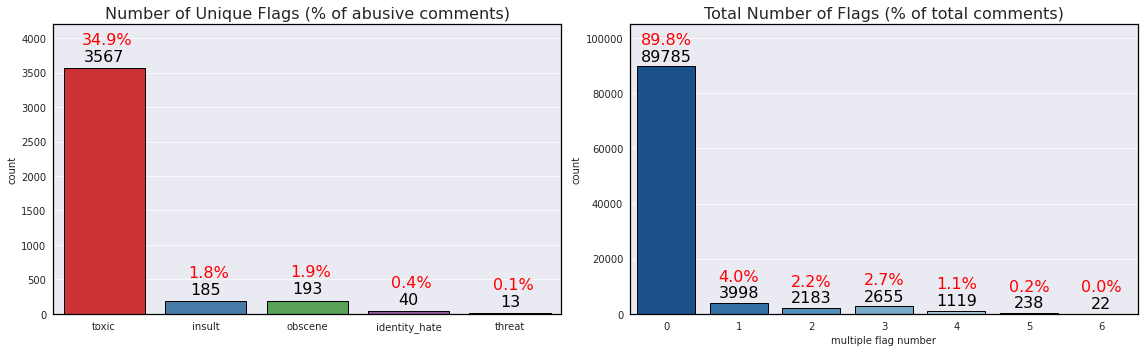

In [13]:
palette = sns.color_palette('Set1',8)

plt.figure(figsize=(16,5))
plt.rcParams["axes.edgecolor"] = 'k'
plt.rcParams["axes.linewidth"]  = 1.25 

plt.subplot(121)
rects = sns.barplot(list(flags.keys()), list(flags.values()), palette=palette, edgecolor='k')
plt.title('Number of Unique Flags (% of abusive comments)', size=16)
plt.ylabel('count')
plt.ylim(top=4200)

plt.subplot(122)
rects2 = sns.barplot(list(count.keys()), list(count.values()), palette='Blues_r', edgecolor='k')
plt.title('Total Number of Flags (% of total comments)', size=16)
plt.xlabel('multiple flag number')
plt.ylabel('count')
plt.ylim(top=105000)

for index, value in enumerate(flags.values()):
    rects.text(index, value + 100, str(value), color='k', ha='center', size=16)
    rects.text(index+.03, value + 350, f"{round(value*100/len(comments[comments.abusive==1]),1)}%", color='r', ha='center', size=16)
for index in sorted(count.keys()):
    rects2.text(index, count[index] + 2000, count[index], color='k', ha='center', size=16)
    rects2.text(index, count[index] + 8000, f"{round(count[index]/1000,1)}%", color='r', ha='center', size=16)

plt.tight_layout()
plt.show()

> There is significant overlap between the classes. With over ten thousand comments flagged as abusive, only the general `toxic` class has a significant amount of uniquely flagged comments, at 3567 observations, with the `threat` class having a mere 13! Also, unique flags account for only 4% of our total documents, at 3998 observations. I anticipate that such class overlap might make detecting noise unique to any particular class a bit problematic.

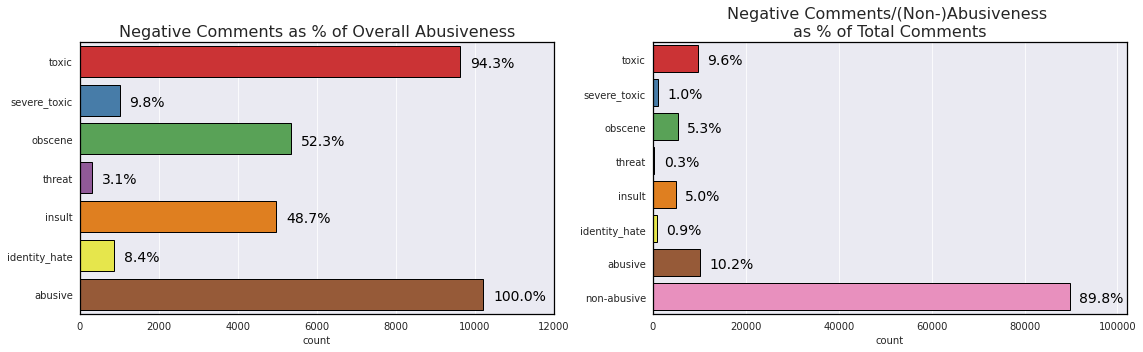

In [25]:
palette = sns.color_palette('Set1',8)

plt.figure(figsize=(16,5))
plt.rcParams["axes.edgecolor"] = 'k'
plt.rcParams["axes.linewidth"]  = 1.25 

plt.subplot(121)
rects = sns.barplot(comments.iloc[:, 1:].sum(axis=0), comments.columns[1:], orient='h', palette=palette, edgecolor='k')
plt.title('Negative Comments as % of Overall Abusiveness', size=16)
plt.xlabel('count')
plt.xlim(right=12000)

plt.subplot(122)
rows = (list(comments.columns[1:]) + ['non-abusive'])
values = (list(comments.iloc[:, 1:].sum(axis=0)) + [len(comments[comments.abusive==0])])
rects2 = sns.barplot(values, rows, orient='h', palette=palette, edgecolor='k')
plt.title('Negative Comments/(Non-)Abusiveness \nas % of Total Comments', size=16)
plt.xlabel('count')
plt.xlim(right=102000)

for index, value in enumerate(values):
    # Making sure our first plot doesn't plot 'non-abusive'
    if index < len(values)-1:
        rects.text(value + 250, index +.15, f'{round(value*100/len(comments[comments.abusive==1]),1)}%', color='k', ha='left', size=14)
        rects2.text(value + 2000, index + .15, f'{round(value*100/len(comments),1)}%', color='k', ha='left', size=14)
    else:
        rects2.text(value + 2000, index + .15, f'{round(value*100/len(comments),1)}%', color='k', ha='left', size=14)

plt.tight_layout()
plt.show()

>All the percentages vary widely for each category of abuse. Furthermore, non-abusive comments comprise almost 90 percent of our observations. Due to these differences, we might have to deal with class imbalance issues later during our modeling.
+ **Note**: It's important to remember that overlap exists between the abusive designations, hence why the sum of the abusive and non-abusive percentages don't add up to 100.

# Word Frequency Comparisons (Lemmatization)
> We can examine which words might prove the most useful in distinguishing one class from another by comparing which words are both more unique and more frequent for each class. There are 15 possible comparisons we could make between the various classes, but below we just examine a few of the similar-sized classes, as well as the two 'toxic' classifications, to get aglimpse at which words might best define a class.

In [26]:
# Utility function to calculate how frequently lemmas appear in the text.
def lemma_frequencies(text, include_stop=True):
    
    # Build a list of lemas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_)
            
    # Build and return a Counter object containing word counts.
    return Counter(lemmas)

In [93]:
# Finding the 20 most common words for each class
freq_dict = {}
corpus_len = {}
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    counter = Counter([])
    target_comments = comments[comments[target]==1]
    for text in target_comments.comment_text:
        counter += lemma_frequencies(nlp(text), include_stop=False)
     # Total word count
    corpus_len[f'{target}'] = sum(counter.values())
     # Take the top 20 most frequent words for each class
    freq_dict[f'{target}_freq'] = counter.most_common(20)

In [96]:
# Identify the lemmas common to one class but not the other.
toxic_percent = {key: round(value*100/corpus_len['toxic'],2) for (key,value) in freq_dict['toxic_freq']}
severe_toxic_percent = {key: round(value*100/corpus_len['severe_toxic'],2) for (key,value) in freq_dict['severe_toxic_freq']}
toxic_common = [key for key in toxic_percent]
severe_toxic_common = [key for key in severe_toxic_percent]

print('\nUnique to Toxic:', set(toxic_common) - set(severe_toxic_common))
print('\nUnique to Severe:', set(severe_toxic_common) - set(toxic_common))

intersection = list(set(toxic_common).intersection(set(severe_toxic_common)))

intersect = dict()
for word in intersection:
    if toxic_percent[word] > severe_toxic_percent[word]:
        intersect[word] = f'toxic({toxic_percent[word]}%)/severe_toxic({severe_toxic_percent[word]}%)'
    else:
        intersect[word] = f'severe_toxic({severe_toxic_percent[word]}%)/toxic({toxic_percent[word]}%)'
print('\nCommon words by greater %:\n', intersect)


Unique to Toxic: {'page', 'know', 'like', 'article', 'fat', 'pig', 'block', 'edit', 'hate'}

Unique to Severe: {'yourselfgo', 'fucker', 'shut', 'bitch', 'rape', 'piece', 'damn', 'faggot', 'kill'}

Common words by greater %:
 {'cunt': 'severe_toxic(1.74%)/toxic(0.58%)', 'nigger': 'severe_toxic(1.28%)/toxic(1.15%)', 'gay': 'severe_toxic(0.84%)/toxic(0.48%)', 'wikipedia': 'severe_toxic(1.15%)/toxic(0.84%)', 'shit': 'severe_toxic(3.31%)/toxic(1.14%)', 'suck': 'severe_toxic(3.58%)/toxic(1.05%)', 'die': 'severe_toxic(1.96%)/toxic(0.73%)', 'ass': 'severe_toxic(3.13%)/toxic(0.81%)', 'fucking': 'severe_toxic(1.46%)/toxic(0.72%)', 'fuck': 'severe_toxic(8.75%)/toxic(2.47%)', 'u': 'severe_toxic(2.51%)/toxic(0.75%)'}


 > The largest disparities in word usage for the `toxic` and `severe_toxic` classes are for the f-word, with `severe_toxic` comprising 8.75% of it's non-stopword corpus while `toxic` is at a lower 2.47%. The s-word also boast a significant disparity at 3.31% and 1.14% for `severe_toxic` and `toxic` respectively.

In [99]:
# Identify the lemmas common to one class but not the other.
threat_percent = {key: round(value*100/corpus_len['threat'],2) for (key,value) in freq_dict['threat_freq']}
identity_hate_percent = {key: round(value*100/corpus_len['identity_hate'],2) for (key,value) in freq_dict['identity_hate_freq']}
threat_common = [key for key in threat_percent]
identity_hate_common = [key for key in identity_hate_percent]

print('\nUnique to Threat:', set(threat_common) - set(identity_hate_common))
print('\nUnique to Identity Hate:', set(identity_hate_common) - set(threat_common))

intersection = list(set(threat_common).intersection(set(identity_hate_common)))

intersect = dict()
for word in intersection:
    if threat_percent[word] > identity_hate_percent[word]:
        intersect[word] = f'threat({threat_percent[word]}%)/identity_hate({identity_hate_percent[word]}%)'
    else:
        intersect[word] = f'identity_hate({identity_hate_percent[word]}%)/threat({threat_percent[word]}%)'
print('\nCommon words by greater %:\n', intersect)


Unique to Threat: {'page', 'wales', 'talk', 'ban', 'fool', 'di', 'forever', 'live', 'jim', 'go', 'supertrll', 'block', 'murder', 'pathetic', 'edie'}

Unique to Identity Hate: {'cunt', 'niggas', 'nigger', 'mexicans', 'gay', 'like', 'bunksteve', 'licker', 'spanish', 'shit', 'fat', 'suck', 'faggot', 'jew', 'hate'}

Common words by greater %:
 {'die': 'threat(11.02%)/identity_hate(2.68%)', 'fucking': 'identity_hate(1.07%)/threat(0.98%)', 'ass': 'threat(7.86%)/identity_hate(0.66%)', 'fuck': 'identity_hate(2.74%)/threat(1.13%)', 'kill': 'threat(4.62%)/identity_hate(0.64%)'}


> There's a large disparity in usage for the word 'die' favoring the `threat` class over the `identity_hate`, 11.02% to 2.68%. the word 'ass' and 'kill' follow next with disparities of 7.86% to 0.66% and 4.62% to 0.64%, both in favor of the `threat` class. There also appears to be more ethnic and racial slurs among the most popular `identity_hate`-related words than in the `threat`-related words.

In [100]:
# Identify the lemmas common to one class but not the other.
obscene_percent = {key: round(value*100/corpus_len['obscene'],2) for (key,value) in freq_dict['obscene_freq']}
insult_percent = {key: round(value*100/corpus_len['insult'],2) for (key,value) in freq_dict['insult_freq']}
obscene_common = [key for key in obscene_percent]
insult_common = [key for key in insult_percent]

print('\nUnique to Obscene:', set(obscene_common) - set(insult_common))
print('\nUnique to insult:', set(insult_common) - set(obscene_common))

intersection = list(set(obscene_common).intersection(set(insult_common)))

intersect = dict()
for word in intersection:
    if obscene_percent[word] > insult_percent[word]:
        intersect[word] = f'obscene({obscene_percent[word]}%)/insult({insult_percent[word]}%)'
    else:
        intersect[word] = f'insult({insult_percent[word]}%)/obscene({obscene_percent[word]}%)'
print('\nCommon words by greater %:\n', intersect)


Unique to Obscene: {'block', 'bullshit'}

Unique to insult: {'jew', 'moron'}

Common words by greater %:
 {'know': 'insult(0.64%)/obscene(0.56%)', 'page': 'obscene(0.58%)/insult(0.57%)', 'cunt': 'insult(1.12%)/obscene(1.02%)', 'fuck': 'obscene(4.32%)/insult(3.63%)', 'like': 'insult(0.88%)/obscene(0.77%)', 'nigger': 'insult(1.94%)/obscene(1.74%)', 'wikipedia': 'obscene(0.82%)/insult(0.63%)', 'bitch': 'insult(0.82%)/obscene(0.74%)', 'shit': 'obscene(1.79%)/insult(0.9%)', 'suck': 'obscene(1.64%)/insult(1.63%)', 'fat': 'insult(0.98%)/obscene(0.84%)', 'fucking': 'insult(1.27%)/obscene(1.24%)', 'ass': 'obscene(1.4%)/insult(1.13%)', 'die': 'insult(0.79%)/obscene(0.66%)', 'dick': 'obscene(0.57%)/insult(0.54%)', 'u': 'insult(1.31%)/obscene(1.19%)', 'edit': 'obscene(0.59%)/insult(0.57%)', 'hate': 'insult(1.02%)/obscene(0.49%)'}


> The `obscene` and `insult` most prevalent common words don't seem to have the same level of disparity as the previous comparisons, with perhaps the word 'hate' having the only somewhat significant disparity, with a prevalence favoring `insult`, 1.02%  to 0.49%. The F-word and S-word are the two words that favor the `obscene` class over the `insult` class, at 4.32% to 3.63% and 1.79% to 0.9%, repectively.

### Functions

In [22]:
def normalize_document(doc, stopwords=True, pos=False):
    # tokenize document
    tokens = nlp(str(doc))
    tokens_list = []
    if pos:
        if not stopwords:
            for tok in tokens:
                if not tok.is_stop:
                    tokens_list.append(str(tok) + f'_{tok.pos_}')
        else:
            for tok in tokens:
                tokens_list.append(str(tok) + f'_{tok.pos_}')
    else:
        if not stopwords:
            for tok in tokens:
                if not tok.is_stop:
                    tokens_list.append(str(tok))
        else:
            for tok in tokens:
                tokens_list.append(str(tok))
    return tokens_list

normalize_corpus = np.vectorize(normalize_document)

In [23]:
def append_scorecard(scores, scorecard):
    to_append = scores
    df_length = len(scorecard)
    scorecard.loc[df_length] = to_append

In [24]:
def targets_vectors(model, input_docs):
    sents = input_docs
    model.random.seed(0)
    targets, feature_vectors = zip(*[(comments.loc[doc.tags[0],'toxic'], model.infer_vector(doc.words, steps=20)) for doc in tqdm(sents,leave=False)])
    return targets, feature_vectors

In [25]:
def model_scores(X, X_norm, Y, stop, pos):
    # models with doc2vec, stopwords=stopwords, pos=pos
    for model,v in {lr:'Logistic Regression', km:'K-Means'}.items():
        scores = []
        scores.extend([f'{(v)} non-Normalized','doc2vec', stop, pos])
        for score in tqdm(['precision','recall','f1','accuracy'], leave=False):
            cv = cross_val_score(model, X, Y, cv=5, scoring=score)
            scores.append(f"{round(cv.mean(), 2)}")
        append_scorecard(scores, scorecard)
        scores = []
        scores.extend([f'{(v)} Normalized','doc2vec',stop, pos])
        for score in tqdm(['precision','recall','f1','accuracy'], leave=False):
            cv = cross_val_score(model, X_norm, Y, cv=5, scoring=score)
            scores.append(f"{round(cv.mean(), 2)}")
        append_scorecard(scores, scorecard)

In [26]:
def highlight_max(s):    
    return ['background-color: lightsteelblue' if v == s.max() else '' for v in s]

In [27]:
def lemmatize_document(doc, pos=False):
    # tokenize document
    tokens = nlp(str(doc))
    tokens_list = []
    if pos:
        for tok in tokens:
            tokens_list.append(str(tok.lemma_) + f'_{tok.pos_}')
    else:
        for tok in tokens:
            tokens_list.append(str(tok.lemma_))
    return tokens_list

lemmatize_corpus = np.vectorize(lemmatize_document)

In [28]:
def norm_lemma_scores(X_norm, Y, stop, pos):
    # models with doc2vec, stopwords=stopwords, pos=pos
    for model,v in {lr:'Lemmatized Log Reg'}.items():
        scores = []
        scores.extend([f'{(v)} Normalized','doc2vec',stop, pos])
        for score in tqdm(['precision','recall','f1','accuracy'], leave=False):
            cv = cross_val_score(model, X_norm, Y, cv=5, scoring=score)
            scores.append(f"{round(cv.mean(), 2)}")
        append_scorecard(scores, scorecard)

In [29]:
########################################################################
#########    Creating a function in order to quickly call upon    ######
#########         the model with different features  while        ######
#########        cycling through different model parameters       ######
########################################################################

def LogReg_RandomSearch(X, Y, d2v_params, C=[1e5, 1e3, 5, 1],
                                          max_iter=[1000, 2000, 3000],
                                          class_weight=['balanced', None],
                                          solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                       ):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    logreg_hyperparams = dict(
                              C = C,
                              max_iter = max_iter,
                              class_weight = class_weight,
                              solver=solver
                              )

    logreg_hyper_table = list()

    # Timed for loop...start the clock!
    start_time = time.time()
    for trial in tqdm(range(10), desc=f'LR Trial', leave=False):
        params = dict()
        for k, v in logreg_hyperparams.items():
            i = np.random.randint(len(v))
            params[k] = v[i]
        #print(params)
        logreg = LogisticRegression(**params)
        logreg.fit(X_train, y_train)
        y_pred_train = logreg.predict(X_train)
        y_pred_test = logreg.predict(X_test)
        params['d2v_params'] = d2v_params
        params['train_precision'] = precision_score(y_train, y_pred_train)
        params['test_precision'] = precision_score(y_test, y_pred_test)
        params['train_recall'] = recall_score(y_train, y_pred_train)
        params['test_recall'] = recall_score(y_test, y_pred_test)
        params['train_acc'] = accuracy_score(y_train, y_pred_train)
        params['test_acc'] = accuracy_score(y_test, y_pred_test)
        params['train_f1'] = f1_score(y_train, y_pred_train)
        params['test_f1'] = f1_score(y_test, y_pred_test)
        
        # Store our parameters and score in a dataframe
        logreg_hyper_table.append(params)

    logreg_hyper_table = pd.DataFrame(data=logreg_hyper_table)
    return logreg_hyper_table.sort_values(by='test_f1', ascending=False).head(3)

In [111]:
d2v_lr = []

def Doc2Vec_RandomSearch(documents, dm=[1,0], vector_size=[100,200,300], 
                                    window=[2,3,4], dm_mean=[0,1], 
                                    iters=[20,50,100], workers=cores, seed=0
                        ):
    model_hyperparams = dict(
                             dm=dm, vector_size=vector_size, 
                             window=window, 
                             dm_mean=dm_mean, iter=iters, 
                            )
    for trial in tqdm(range(10), position=0, desc=f'Model Trial', leave=False):
        params = dict()
        for k, v in model_hyperparams.items():
            i = np.random.randint(len(v))
            params[k] = v[i]
        
        model = Doc2Vec(**params, workers=workers, seed=seed)
        model.build_vocab([x for x in tqdm(documents, desc='Build vocab:', leave=False)])
        model.train(tqdm(documents, 
                         desc=f"Train Model #{trial}:",
                         leave=False), total_examples=model.corpus_count, epochs=model.iter)

        Y, X = targets_vectors(model, documents)
        X_norm = preprocessing.normalize(X, norm='l2')

        # Call the Logistic Regression function
        logreg_hyper_df = LogReg_RandomSearch(X_norm, Y, params)
        d2v_lr.append(logreg_hyper_df)
    return d2v_lr

## Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB
nb =  MultinomialNB()

In [13]:
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    nb.fit(X_train, y_train.loc[:, target])
    y_pred = nb.predict(X_test)

    # print(f'Log_loss score for {target} is {log_loss(y_test.loc[:, target], y_pred, eps=1e-15)}')
    print(f'Confusion Matrix for {target}:\n {confusion_matrix(y_test.loc[:, target], y_pred)}')
    print(classification_report(y_test.loc[:, target], y_pred)[:217])
    num = sum(y_test.loc[:, target])
    print(f'Class Balance: {round(1 - num/30000, 3)}/{round(num/30000, 3)}')
    print('-'*100)

Confusion Matrix for toxic:
 [[27050   106]
 [ 1448  1396]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27156
           1       0.93      0.49      0.64      2844

    accuracy                           0.95     30000
Class Balance: 0.905/0.095
----------------------------------------------------------------------------------------------------
Confusion Matrix for severe_toxic:
 [[29665    19]
 [  285    31]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29684
           1       0.62      0.10      0.17       316

    accuracy                           0.99     30000
Class Balance: 0.989/0.011
----------------------------------------------------------------------------------------------------
Confusion Matrix for obscene:
 [[28344    78]
 [  730   848]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     28422
          

> With the `toxic` class being the predominant classification, we'll use it as the primary class for comparison between the various models, then we'll use the remaining classes for complimentary examination. Beginning with the Naive Bayes algorithm, we can see that the model improves accuracy to 93%, from the majority class baseline of 90%. So there is _some_ improvement, as this model would outperform a 'skill-less' model. It has a high precision but low recall, resulting in a low f1 score.

> When we examine the other classes, there are even more stark class imbalances with majority classes as high as 99% in some cases. With these classes, accuracy scores are near meaningless. Therefore, we will be comparing f1 scores so that we can capture the precision and recall characteristics. The `toxic`, `obscene` and `insult` classes have more flagged observations, and thus appear to be capturikng more signal, judging from the f1 scores. The `severe_toxic`, `threat`  and `identity_hate` classes have so few flagged observations Naive Bayes doesn't seem to be capturing much signal with f1 scores of 0.17, 0.0 and 0.09, respectively.

# Doc2vec

In [104]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

### Models

In [30]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

# K-Means

from sklearn.cluster import KMeans
km = KMeans(init='random', n_clusters=2, n_jobs=-1, random_state=0)

In [107]:
scorecard = pd.DataFrame(columns=['model','algorithm','stopwords','pos','precision','recall','f1','accuracy'])

In [ ]:
for bul_stop in [True, False]:
    stopwords = bul_stop
    for bul_pos in [True, False]:
        pos = bul_pos
        
        # Prepare document
        documents = np.empty(len(comments), dtype=object)

        # normalize corpus, stopwords=stopwords, pos=pos
        for i, doc in enumerate(tqdm(comments.comment_text, 
                                     desc=f"Tag Docs: stop={stopwords}, pos={pos}", 
                                     leave=False)):
            documents[i] = TaggedDocument(normalize_corpus(doc, stopwords=stopwords, pos=pos), [i])
        model = Doc2Vec(dm=1, vector_size=300, window=2, min_count=2, workers=cores, dm_mean=0, iter=20, seed=0)
        model.build_vocab([x for x in tqdm(documents, leave=False)])
        model.train(tqdm(documents, 
                         desc=f"Train Model: stop={stopwords}, pos={pos}",
                         leave=False), total_examples=model.corpus_count, epochs=model.iter)

        Y, X = targets_vectors(model, documents)
        X_norm = preprocessing.normalize(X, norm='l2')
        
        model_scores(X, X_norm, Y, bul_stop, bul_pos)

In [31]:
# scorecard = scorecard.sort_values(by='f1', ascending=False)
# scorecard.reset_index(drop=True, inplace=True)

# with open('scorecard.csv', mode='wt') as fout:
#             scorecard.to_csv(fout,index=False)

scorecard = pd.read_csv('scorecard.csv')
        
scorecard.style.apply(highlight_max, subset=['precision','recall','f1','accuracy'])

,model,algorithm,stopwords,pos,precision,recall,f1,accuracy
0,Logistic Regression Normalized,doc2vec,True,False,0.81,0.54,0.65,0.94
1,Logistic Regression Normalized,doc2vec,True,True,0.8,0.52,0.63,0.94
2,Logistic Regression Normalized,doc2vec,False,False,0.82,0.49,0.62,0.94
3,Logistic Regression Normalized,doc2vec,False,True,0.81,0.46,0.59,0.94
4,Logistic Regression non-Normalized,doc2vec,True,False,0.76,0.47,0.58,0.93
5,Logistic Regression non-Normalized,doc2vec,True,True,0.75,0.43,0.55,0.93
6,Logistic Regression non-Normalized,doc2vec,False,False,0.78,0.37,0.5,0.93
7,Logistic Regression non-Normalized,doc2vec,False,True,0.75,0.34,0.47,0.93
8,K-Means non-Normalized,doc2vec,False,True,0.1,0.95,0.18,0.16
9,K-Means Normalized,doc2vec,True,True,0.1,0.53,0.16,0.47


> Clearly the Normalized, Logistic Regression is superior to the K-means classifier and slightly edge out the non-Normalized Logistic Regression. The inclusion of stopwords is a clear boost in sentiment retention. The inclusion of parts of speech (pos) seems to underperform the exclusion of parts of speech, albeit not by much. The Logistic Regression, Normalized	doc2vec	model, with stopwords=True and pos=False, was the top scorer in all categories except recall, where it scored second, and precision where it score a close second. Next, we'll examine whether lemmas can provide additional sentiment retention, keeping stopwords throughout and, again, comparing with and without parts of speech..

In [ ]:
for bul_pos in [True, False]:
    pos = bul_pos

    # Prepare document
    documents = np.empty(len(comments), dtype=object)

    # normalize corpus, stopwords=stopwords, pos=pos
    for i, doc in enumerate(tqdm(comments.comment_text, 
                                 desc=f"Tag Docs: w/ lemmas, pos={pos}", 
                                 leave=False)):
        documents[i] = TaggedDocument(lemmatize_corpus(doc, pos=pos), [i])

    model = Doc2Vec(dm=1, vector_size=300, window=2, min_count=2, workers=cores, dm_mean=0, iter=20, seed=0)
    model.build_vocab([x for x in tqdm(documents, leave=False)])
    model.train(tqdm(documents, 
                     desc=f"Train Model: w/ lemmas, pos={pos}",
                     leave=False), total_examples=model.corpus_count, epochs=model.iter)

    Y, X = targets_vectors(model, documents)
    X_norm = preprocessing.normalize(X, norm='l2')

    norm_lemma_scores(X_norm, Y, True, bul_pos)

In [32]:
# scorecard = scorecard.sort_values(by='f1', ascending=False)
# scorecard.reset_index(drop=True, inplace=True)

# with open('lemma_scorecard.csv', mode='wt') as fout:
#             scorecard.to_csv(fout,index=False)

scorecard = pd.read_csv('lemma_scorecard.csv')
        
scorecard.head().style.apply(highlight_max, subset=['precision','recall','f1','accuracy'])

,model,algorithm,stopwords,pos,precision,recall,f1,accuracy
0,Lemmatized Log Reg Normalized,doc2vec,True,False,0.82,0.55,0.66,0.94
1,Logistic Regression Normalized,doc2vec,True,False,0.81,0.54,0.65,0.94
2,Logistic Regression Normalized,doc2vec,True,True,0.8,0.52,0.63,0.94
3,Lemmatized Log Reg Normalized,doc2vec,True,True,0.81,0.52,0.63,0.94
4,Logistic Regression Normalized,doc2vec,False,False,0.82,0.49,0.62,0.94


> Lemmatization has earned slight improvements for f-1, recall and precision scores while maintaining its accuracy score. Again, the exclusion of parts of speech tags slightly underperformed the model with its inclusion. We'll now run a Logistic Regression random search to tune hyperparameters.

In [ ]:
# Prepare document
documents = np.empty(len(comments), dtype=object)

# normalize corpus, stopwords=stopwords, pos=pos
for i, doc in enumerate(tqdm(comments.comment_text, 
                             desc=f"Tag Docs: w/ lemmas, pos=False", 
                             leave=False)):
    documents[i] = TaggedDocument(lemmatize_corpus(doc, pos=False), [i])

In [19]:
# RUN ONCE
# results = pd.concat(Doc2Vec_RandomSearch(documents))

In [33]:
# results = results.sort_values(by='test_f1', ascending=False)
# results.reset_index(drop=True, inplace=True)

# with open('final_scorecard.csv', mode='wt') as fout:
#             results.to_csv(fout,index=False) 
results = pd.read_csv('final_scorecard.csv').head()
        
results.style.apply(highlight_max, subset=['test_precision','test_recall','test_f1','test_acc'])

,C,max_iter,class_weight,solver,d2v_params,train_precision,test_precision,train_recall,test_recall,train_acc,test_acc,train_f1,test_f1
0,1000,1000,nan,sag,"{'dm': 0, 'vector_size': 300, 'window': 3, 'dm_mean': 1, 'iter': 50}",0.830483,0.820856,0.660165,0.647679,0.954114,0.9532,0.735594,0.724057
1,5,2000,nan,sag,"{'dm': 0, 'vector_size': 300, 'window': 3, 'dm_mean': 1, 'iter': 50}",0.835995,0.828204,0.657506,0.633966,0.954414,0.952833,0.736085,0.718184
2,5,2000,nan,saga,"{'dm': 0, 'vector_size': 300, 'window': 3, 'dm_mean': 1, 'iter': 50}",0.835995,0.828204,0.657506,0.633966,0.954414,0.952833,0.736085,0.718184
3,100000,2000,nan,newton-cg,"{'dm': 0, 'vector_size': 300, 'window': 3, 'dm_mean': 1, 'iter': 50}",0.832091,0.822808,0.659722,0.636779,0.954229,0.952567,0.735949,0.717939
4,1,3000,nan,sag,"{'dm': 0, 'vector_size': 300, 'window': 3, 'dm_mean': 1, 'iter': 50}",0.843574,0.835905,0.643026,0.628692,0.953957,0.9531,0.729773,0.71764


# The Best Doc2vec Recipe

> + Lemmatized documents, normalized vectors
+ Doc2Vec(dm=0, vector_size=300, window=3, dm_mean=1, iter=50)
+ LogisticRegression(C=1000, max_iter=1000, class_weight=None, solver='sag')

With the above pipeline, we've managed to maximize our preferred criteria, `test_f1`. With a test accuracy of 0.9532, we've captured over 50% of the remaining accuracy that was up for grabs when given a baseline accuracy of nearly 90% for all non-abusive comments. Our recall score represents our minority class, and we are capturing almost 65% of the `toxic` comments with over 82% of the observations predicted to be `toxic` actually being toxic.

In [206]:
# Modified targets_vectors function, now taking 'target' as a parameter
def targets_vectors(model, input_docs, target):
    sents = input_docs
    model.random.seed(0)
    targets, feature_vectors = zip(*[(comments.loc[i,target], model.infer_vector(doc.words, steps=20)) for i, doc in tqdm(enumerate(sents),leave=False)])
    return targets, feature_vectors

> We now extend our optimal model to all of the classes.

In [119]:
# Use optimal random search criteria
lr = LogisticRegression(C=1, max_iter=1000, class_weight=None, solver='sag')
model = Doc2Vec(dm=0, vector_size=300, window=3, dm_mean=1, iter=50, workers=cores, seed=0)                
model.build_vocab([x for x in tqdm(documents, desc='Build vocab:', leave=False)])
model.train(tqdm(documents, 
                 desc=f"Train Model:",
                 leave=False), total_examples=model.corpus_count, epochs=model.iter)
                    
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    Y, X = targets_vectors(model, documents, target)
    X_norm = preprocessing.normalize(X, norm='l2')
                
    X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.3, random_state=0)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    log_loss = np.mean(cross_val_score(lr, X_norm, Y, cv=5, scoring='neg_log_loss'))
    print(f'Log_loss score for {target} is {log_loss}')
    print(f'Confusion Matrix for {target}:\n {confusion_matrix(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))          

Log_loss score for toxic is -0.12608957538569543
Confusion Matrix for toxic:
 [[26807   349]
 [ 1041  1803]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27156
           1       0.84      0.63      0.72      2844

    accuracy                           0.95     30000
   macro avg       0.90      0.81      0.85     30000
weighted avg       0.95      0.95      0.95     30000



Log_loss score for severe_toxic is -0.027014954122679874
Confusion Matrix for severe_toxic:
 [[29627    57]
 [  262    54]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29684
           1       0.49      0.17      0.25       316

    accuracy                           0.99     30000
   macro avg       0.74      0.58      0.62     30000
weighted avg       0.99      0.99      0.99     30000



Log_loss score for obscene is -0.06876860305325452
Confusion Matrix for obscene:
 [[28242   180]
 [  540  1038]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     28422
           1       0.85      0.66      0.74      1578

    accuracy                           0.98     30000
   macro avg       0.92      0.83      0.86     30000
weighted avg       0.97      0.98      0.97     30000



Log_loss score for threat is -0.010428913922936826
Confusion Matrix for threat:
 [[29903     1]
 [   87     9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29904
           1       0.90      0.09      0.17        96

    accuracy                           1.00     30000
   macro avg       0.95      0.55      0.58     30000
weighted avg       1.00      1.00      1.00     30000



Log_loss score for insult is -0.08016496842596106
Confusion Matrix for insult:
 [[28266   257]
 [  669   808]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     28523
           1       0.76      0.55      0.64      1477

    accuracy                           0.97     30000
   macro avg       0.87      0.77      0.81     30000
weighted avg       0.97      0.97      0.97     30000



Log_loss score for identity_hate is -0.025609311483858456
Confusion Matrix for identity_hate:
 [[29733    16]
 [  214    37]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29749
           1       0.70      0.15      0.24       251

    accuracy                           0.99     30000
   macro avg       0.85      0.57      0.62     30000
weighted avg       0.99      0.99      0.99     30000



> Although still low in some cases, the f1 score for the classes, other than `toxic`, have made improvements with the Doc2vec model:

+ toxic: 0.72 (up from 0.64 for Naive Bayes)
+ severe_toxic: 0.25 (up from 0.17)
+ obscene: 0.74 (up from 0.68)
+ threat: 0.17 (up from 0.00)
+ insult: 0.64 (up from 0.57)
+ identity_hate: 0.24 (up from 0.09)


# TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=100, stop_words='english',lowercase=True, 
                                   use_idf=True, token_pattern=r'\w{2,}', sublinear_tf=True)
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=100, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=True, token_pattern='\\w{2,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [17]:
vectors = tfidf_vectorizer.fit_transform(comments.comment_text)
vectors = vectors.todense()
vectors = pd.DataFrame(vectors, columns=tfidf_vectorizer.get_feature_names())
vectors.shape

(100000, 3412)

In [18]:
vectors['unique_words'] = 0
for idx, comment in enumerate(comments.comment_text):
    val = len(set(comment))/(len(comment) + 1)
    vectors['unique_words'].iloc[idx] 

In [19]:
vectors.head(1)

,ability,able,absence,absolute,absolutely,absurd,abuse,abused,abusing,abusive,...,yep,yes,yesterday,yo,york,young,youre,youtube,zero,unique_words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.269097,0.0,0.0,0.0,0.0,0


In [20]:
Y = comments.iloc[:, 1:]
Y.head(1)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0


In [28]:
# Call the Logistic Regression function
# logreg_hyper_df = LogReg_RandomSearch(vectors,Y.loc[:,'toxic'])

with open('tfidf_scorecard.csv', mode='wt') as fout:
    logreg_hyper_df.to_csv(fout,index=False)
logreg_hyper_df.style.apply(lambda x: ['background: lightblue' if x.name == 'test_f1' else '' for i in x])

,C,max_iter,class_weight,solver,train_precision,test_precision,train_recall,test_recall,train_acc,test_acc,train_f1,test_f1
25,5,3000,None,sag,0.909903,0.872602,0.66253,0.623769,0.961029,0.9557,0.766758,0.727496
6,1000,1000,None,lbfgs,0.896705,0.795181,0.715721,0.649789,0.964543,0.950933,0.796056,0.71517
7,1000,1000,None,saga,0.896501,0.795181,0.715426,0.649789,0.9645,0.950933,0.795793,0.71517
11,1000,3000,None,sag,0.896705,0.795181,0.715721,0.649789,0.964543,0.950933,0.796056,0.71517
26,100000,3000,None,saga,0.896456,0.79006,0.717642,0.648383,0.964686,0.950333,0.797144,0.712244


In [21]:
X_train, X_test, y_train, y_test = train_test_split(vectors, Y, test_size=0.3, random_state=0)

In [22]:
# Running again with tuned hyperparameters
lr = LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag')

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    lr.fit(X_train, y_train.loc[:, target])
    y_pred = lr.predict(X_test)

    print(f'Log_loss score for {target} is {log_loss(y_test.loc[:, target], y_pred, eps=1e-15)}')
    print(f'Confusion Matrix for {target}:\n {confusion_matrix(y_test.loc[:, target], y_pred)}')
    print(classification_report(y_test.loc[:, target], y_pred)[:217])
    num = sum(y_test.loc[:, target])
    print(f'Class Balance: {round(1 - num/30000, 3)}/{round(num/30000, 3)}')
    print('-'*100)

Log_loss score for toxic is 1.5335290548836404
Confusion Matrix for toxic:
 [[26884   277]
 [ 1055  1784]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27161
           1       0.87      0.63      0.73      2839

    accuracy                           0.96     30000
Class Balance: 0.905/0.095
----------------------------------------------------------------------------------------------------
Log_loss score for severe_toxic is 0.3258173632002711
Confusion Matrix for severe_toxic:
 [[29639    59]
 [  224    78]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29698
           1       0.57      0.26      0.36       302

    accuracy                           0.99     30000
Class Balance: 0.99/0.01
----------------------------------------------------------------------------------------------------
Log_loss score for obscene is 0.7897900452061652
Confusion Matrix for obscene:
 [[

# The Best TF-IDF Recipe
> + TfidfVectorizer(max_df=0.9, min_df=100, ngram_range=(1, 1), smooth_idf=True, token_pattern='\\w{2,}', use_idf=True)
> + LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag')

With the above pipeline, we've managed to maximize our preferred criteria, test_f1. The test accuracy has increased to 96%, capturing nearly 60% of the remaining accuracy above the `toxic` baseline of 90%. Our recall scores have fallen slightly to 63% but the precision has risen to 87% for a comparable f1 score of 0.73. Again, we'll compare TF-IDF with the Doc2vec model:
+ toxic: 0.73 (up from 0.72 for Doc2vec/Logistic Regression)
+ severe_toxic: 0.30 (up from 0.25)
+ obscene: 0.77 (up from 0.74)
+ threat: 0.25 ( up from 0.17)
+ insult: 0.64 (same as 0.64 for Doc2vec/Logistic Regression)
+ identity_hate: 0.35 (up from 0.24)

Our TF-IDF model has matched, or outperformed, Doc2vec with every class.

## Targeted Features
> With the following model, we will create features, using the most common words flagged for each class.

In [6]:
def lemmatize_document(doc, pos=False):
    # tokenize document
    tokens = nlp(str(doc))
    tokens_list = []
    if pos:
        for tok in tokens:
            # Lemmas and POS
            tokens_list.append(str(tok.lemma_) + f'_{tok.pos_}')
    else:
        for tok in tokens:
            # Only the lemmas
            tokens_list.append(str(tok.lemma_))
    return tokens_list

# Vectorize the document
lemmatize_corpus = np.vectorize(lemmatize_document)

In [7]:
# Lemmatize the documents (without vectorization)
# comments['comment_text'] = comments['comment_text'].apply(lemmatize_document)

# comments.to_pickle('lemmatized_comments.pkl')
    
lemma_coms = pd.read_pickle('lemmatized_comments.pkl')
lemma_coms.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, why, the, edit, make, under, -PR...",0,0,0,0,0,0
1,"[d'aww, -PRON-, match, this, background, colou...",0,0,0,0,0,0
2,"[hey, man, -PRON-, be, really, not, try, to, e...",0,0,0,0,0,0
3,"[more, i, can, not, make, any, real, suggestio...",0,0,0,0,0,0
4,"[-PRON-, sir, be, -PRON-, hero, any, chance, -...",0,0,0,0,0,0


In [9]:
target_comments = lemma_coms[lemma_coms['toxic']==1].comment_text.reset_index(drop=True)

In [56]:
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    start_time = time.time()
    target_comments = lemma_coms[lemma_coms[target]==1].comment_text.reset_index(drop=True)

    ###### CREATE TARGETED BOWS ######
    bows = []
    counter = Counter([])
    for i in range(len(target_comments)):
        counter += Counter(target_comments[i])
    words = counter.most_common(2000)
    for i, word in enumerate(words):
        # 'words' is an array of tuples, (word, count)
        if word[0] in string.punctuation or word[0] in stopwords.words('english'):
            continue
        elif word[0] != '-PRON-':
            # Appending non-punctuation/stopwords to our BOW list
            bows.append(word[0])

    # Use custom BOW for vocabulary
    bow_vectorizer = TfidfVectorizer(max_df=0.9, min_df=100, stop_words='english',lowercase=False, 
                                       use_idf=True, token_pattern=r'\w{2,}', sublinear_tf=True, vocabulary=bows)

    # Vectorize
    vectors = bow_vectorizer.fit_transform(comments.comment_text)
    vectors = vectors.todense()
    vectors = pd.DataFrame(vectors, columns=bow_vectorizer.get_feature_names())

    # Use our tuned parameters
    lr = LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag', random_state=0)

    X_train, X_test, y_train, y_test = train_test_split(vectors, Y, test_size=0.3, random_state=0)

    lr.fit(X_train, y_train.loc[:, target])
    y_pred = lr.predict(X_test)

    # print(f'Log_loss score for {target} is {log_loss(y_test.loc[:, target], y_pred, eps=1e-15)}')
    print(f'Confusion Matrix for {target}:\n {confusion_matrix(y_test.loc[:, target], y_pred)}')
    print(classification_report(y_test.loc[:, target], y_pred)[:217])
    num = sum(y_test.loc[:, target])
    print(f'Class Balance: {round(1 - num/30000, 3)}/{round(num/30000, 3)}')
    
    end_time = time.time()
    print(f'Execution time: {round(end_time - start_time, 2)} seconds')
    print('-'*100)

Confusion Matrix for toxic:
 [[26887   269]
 [ 1025  1819]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27156
           1       0.87      0.64      0.74      2844

    accuracy                           0.96     30000
Class Balance: 0.905/0.095
Execution time: 31.41 seconds
----------------------------------------------------------------------------------------------------
Confusion Matrix for severe_toxic:
 [[29630    54]
 [  266    50]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29684
           1       0.48      0.16      0.24       316

    accuracy                           0.99     30000
Class Balance: 0.989/0.011
Execution time: 34.91 seconds
----------------------------------------------------------------------------------------------------
Confusion Matrix for obscene:
 [[28274   148]
 [  483  1095]]
              precision    recall  f1-score   support

    

# The Best (TFIDF, Targeted Features) Recipe
> + TfidfVectorizer(max_df=0.9, min_df=100, use_idf=True, token_pattern=r'\w{2,}', sublinear_tf=True, vocabulary=bows)
+ LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag', random_state=0)

We now compare the TF-IDF model with algorithmically generated features to our TF-IDF, target features model:

+ toxic: 0.74 (up from 0.73 for TF-IDF)
+ severe_toxic: 0.24 (DOWN from 0.30)
+ obscene: 0.78 (up from 0.77)
+ threat: 0.09 (DOWN from 0.25)
+ insult: 0.64 (same as 0.64 for TF-IDF)
+ identity_hate: 0.25 (DOWN from 0.35)

The targeted TF-IDF model has performed worse than the 'out-of-the-box' TF-IDF model.

## Bigrams

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english',lowercase=True, ngram_range=(1,2),
                                   max_features=3000, use_idf=True, token_pattern=r'\w{2,}', sublinear_tf=True)
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=3000,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=True, token_pattern='\\w{2,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [16]:
bigram_vectors = tfidf_vectorizer.fit_transform(comments.comment_text)
bigram_vectors = bigram_vectors.todense()
bigram_vectors = pd.DataFrame(bigram_vectors, columns=tfidf_vectorizer.get_feature_names())
bigram_vectors.shape

(100000, 3000)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(bigram_vectors, Y, test_size=0.3, random_state=0)

# Running again with tuned hyperparameters
lr = LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag')

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    lr.fit(X_train, y_train.loc[:, target])
    y_pred = lr.predict(X_test)

    print(f'Log_loss score for {target} is {log_loss(y_test.loc[:, target], y_pred, eps=1e-15)}')
    print(f'Confusion Matrix for {target}:\n {confusion_matrix(y_test.loc[:, target], y_pred)}')
    print(classification_report(y_test.loc[:, target], y_pred)[:217])
    num = sum(y_test.loc[:, target])
    print(f'Class Balance: {round(1 - num/30000, 3)}/{round(num/30000, 3)}')
    print('-'*100)

Log_loss score for toxic is 1.586488565328999
Confusion Matrix for toxic:
 [[26882   279]
 [ 1099  1740]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27161
           1       0.86      0.61      0.72      2839

    accuracy                           0.95     30000
Class Balance: 0.905/0.095
----------------------------------------------------------------------------------------------------
Log_loss score for severe_toxic is 0.3154554904025688
Confusion Matrix for severe_toxic:
 [[29648    50]
 [  224    78]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29698
           1       0.61      0.26      0.36       302

    accuracy                           0.99     30000
Class Balance: 0.99/0.01
----------------------------------------------------------------------------------------------------
Log_loss score for obscene is 0.8013031305906215
Confusion Matrix for obscene:
 [[2

# The Best Bigrams, TF-IDF Recipe
> + TfidfVectorizer(max_df=0.9, min_df=100, use_idf=True, token_pattern=r'\w{2,}', sublinear_tf=True, vocabulary=bows)
+ LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag', random_state=0)

We now compare the TF-IDF model with algorithmically generated features to our TF-IDF, target features model:

+ toxic: 0.72 (DOWN from 0.73 for TF-IDF)
+ severe_toxic: 0.36 (up from 0.30)
+ obscene: 0.75 (DOWN from 0.77)
+ threat: 0.27 (up from 0.25)
+ insult: 0.62 (DOWN from 0.64)
+ identity_hate: 0.29 (DOWN from 0.35)

The bigrams TF-IDF model has performed worse than the 'out-of-the-box' TF-IDF model for four out of six classes, including the primary class of `toxic`.

# Conclusion
> Without a clear set of directives determining what makes a comment fall into one, or more, of the abusive categories, it's hard to gauge whether we are capturing a set of hard and fast rules with which these comments were originally classified or if we're simply back-engineering the subjective biases of the humans who originally flagged these comments. Are these moderator flagged comments? Community flagged comments? Do some of the flagged comments become toxic only after they borrow context from other comments they were replying to; comments which may have avoided being flagged themselves?

Some of the **false positives** in our model seem to convey language that, given a certain context, could most certainly be classified as toxic.

In [329]:
print("-->", comments.comment_text.iloc[71077], '\n')
print("-->", comments.comment_text.iloc[70963], '\n')
print("-->", comments.comment_text.iloc[71658])

--> yo mama yo mama yo mama 

--> bite me irishguy contextflexed 

--> the block page says i should add this to my page so there it goes someone fix this and get these power corrupt idiots to stop stalking me


> They typically tend to convey dissatisfaction of some kind, with some of them even getting away with use of bad words, albeit not always in a manner meant to insult.

In [347]:
print("-->", comments.comment_text.iloc[71301].replace('itc','***'), '\n')
print("-->", comments.comment_text.iloc[71252].replace('unt','***'))

--> nan bread is a b***h to make how do you do it i can make chicken marsala but not the indan breads 

--> thanks sorry i didn't know you weren't allowed to write things like that on articles my bad c***


> Some of the **false negatives** have contextually harsh language, but which contain words that, on their own, don't necessarily convey toxicity.

In [354]:
print("-->", comments.comment_text.iloc[70096], '\n')
print("-->", comments.comment_text.iloc[70121])

--> baby eaters alright is it true that some of the band's songs translate into lyrics like i'm going to cut open your fetus and eat your baby or other horrific lyrics 

--> you love the devil and worship him


> Other false negatives seem to convey mild dissatisfaction, but nothing that seems obviously toxic. Perhaps some of these abusive comments borrow context from the comments they were replying to? If so, that makes classification that much trickier.

In [375]:
print("-->", comments.comment_text.iloc[73781])

--> whats the deal you can put crap on my talk page but i cant put crap on yours you're real cool dude


> Perhaps this one escaped detection by our model due to a convenient typo.

In [374]:
print("-->", comments.comment_text.iloc[70122])

--> go and complain me again for personal attack looser i do not care


> In the end, whatever it is we're capturing, the TF-IDF, with algorithm generated features, outperformed all our other models across all models (though slightly outperformed by targeted BOWS in the `toxic` class. It also requires the least amount of text modification (no lemmatization) and supplementary functions. With it being the quickest, and easiest model to run, it is the clear winner, performing as well, or better than any of the other models, and in each and every class. Unfortunately, none of the models managed to post impressive results across the board, most likely due to some of the classes having too few instances with which to train a model adequately. A possible solution might be to allow content providers to manually add words to the feature set that they want to trigger an automatic comment flag, either for automatic removal or for human review.

# DEMO

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=100, stop_words='english',lowercase=True, 
                                   use_idf=True, token_pattern=r'\w{2,}', sublinear_tf=True)

lr = LogisticRegression(C=5, class_weight=None, max_iter=3000, solver='sag')

vectors = tfidf_vectorizer.fit_transform(comments.comment_text)
vectors = vectors.todense()
vectors = pd.DataFrame(vectors, columns=tfidf_vectorizer.get_feature_names())

vectors['unique_words'] = 0
for idx, comment in enumerate(comments.comment_text):
    val = len(set(comment))/(len(comment) + 1)
    vectors['unique_words'].iloc[idx]
    
Y = comments.iloc[:, 1:]
    
X_train, X_test, y_train, y_test = train_test_split(vectors, Y, test_size=0.3, random_state=0)

lr.fit(X_train, y_train.loc[:, 'toxic'])

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
columns=tfidf_vectorizer.get_feature_names()
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english',lowercase=True, use_idf=True, token_pattern=r'\w{2,}', 
                                    sublinear_tf=True, vocabulary=columns)

def toxicity_detector(threshold=0.5):
    text = str(input('Enter text for toxicity evaluation: ')).lower().strip()
    text = tfidf_vectorizer2.fit_transform([text])
    text = text.todense()
    text = pd.DataFrame(text, columns=tfidf_vectorizer.get_feature_names())
    text['unique_words'] = len(set(comment))/(len(comment) + 1)
    
    prob = lr.predict_proba(text)
    prob = prob[0][1]
    
    if prob >= threshold:
        print(prob, 'This comment is toxic')
    # elif prob >= 
    else:
        print(prob, 'This comment is acceptable')

In [11]:
toxicity_detector(0.4)

Enter text for toxicity evaluation: hello world!
0.12598498704133926 This comment is acceptable
